In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import pandas as pd
# Constants
E = 210e9  # Young's modulus for steel in Pascals

1D HOOKE'S LAWS

In [3]:
# Multi layer perceptron  PINN model 
class MLP(eqx.Module):
    layers: list
    activation: callable

    def __init__(self, key, sizes, activation=jax.nn.tanh):
        self.layers = [eqx.nn.Linear(sizes[i], sizes[i+1], key=subkey) for i, subkey in enumerate(jax.random.split(key, len(sizes) - 1))]
        self.activation = activation

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)


In [4]:
# calling model by using random key
key = jax.random.PRNGKey(0)
model = MLP(key, [1, 64, 64, 1])

In [5]:
#Calculating the possible residual in Strain and also stress using Hooke's law in 1D
def stress_strain_residual(model, x):
    displacement_grad = jax.grad(lambda x: model(x).squeeze())(x)  # Strain
    stress = E * displacement_grad          # Stress using Hooke's Law
    return stress
#Our loss function in tersm of difference of stress level
def loss_fn(model, x):
    stress = jax.vmap(stress_strain_residual, in_axes=[None, 0])(model, x)
    stress_true = jnp.zeros_like(stress)  # Assuming zero stress as boundary condition
    loss = jnp.mean((stress - stress_true)**2)
    return loss


In [6]:
#Optimization processes
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

@eqx.filter_jit
def train_step(model, opt_state, x):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

In [7]:
#Our x values  to train our model(the interval is 0 -1 and 100 different value)
x_train = jnp.linspace(0, 1, 100).reshape(-1, 1)  # Reshape to (100, 1)

In [8]:
#Epoch processes by training our model in  train step
loss_history = []
for epoch in range(10000):
    model, opt_state, loss = train_step(model, opt_state, x_train)
    loss_history.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 3.298846616864707e+20
Epoch 100, Loss: 1.84241469107355e+19
Epoch 200, Loss: 3.0791056913701274e+17
Epoch 300, Loss: 1.9422397022286643e+17
Epoch 400, Loss: 1.166708452706222e+17
Epoch 500, Loss: 6.746968849750426e+16
Epoch 600, Loss: 3.822914312444314e+16
Epoch 700, Loss: 2.270353213410509e+16
Epoch 800, Loss: 1.582629950324736e+16
Epoch 900, Loss: 1.3273422482112512e+16
Epoch 1000, Loss: 1.234848194756608e+16
Epoch 1100, Loss: 1.1897663926566912e+16
Epoch 1200, Loss: 1.1552963810033664e+16
Epoch 1300, Loss: 1.1221814315319296e+16
Epoch 1400, Loss: 1.0884777494183936e+16
Epoch 1500, Loss: 1.0540014026883072e+16
Epoch 1600, Loss: 1.0187103006621696e+16
Epoch 1700, Loss: 9826762766680064.0
Epoch 1800, Loss: 9459950011023360.0
Epoch 1900, Loss: 9086272823885824.0
Epoch 2000, Loss: 8707071771934720.0
Epoch 2100, Loss: 8322156802867200.0
Epoch 2200, Loss: 7932027743502336.0
Epoch 2300, Loss: 7537054497898496.0
Epoch 2400, Loss: 7137375041880064.0
Epoch 2500, Loss: 6733621272

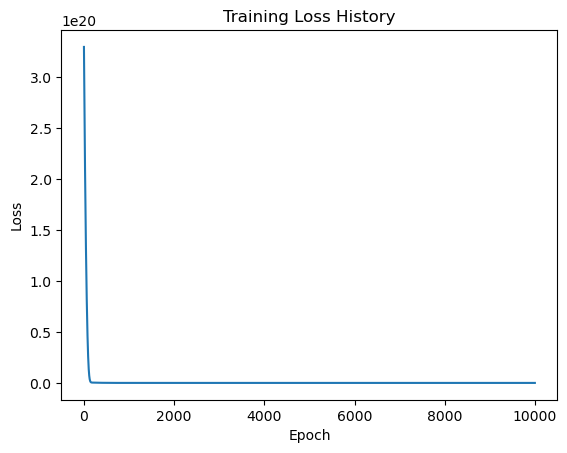

In [9]:
#Loss function visualization
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

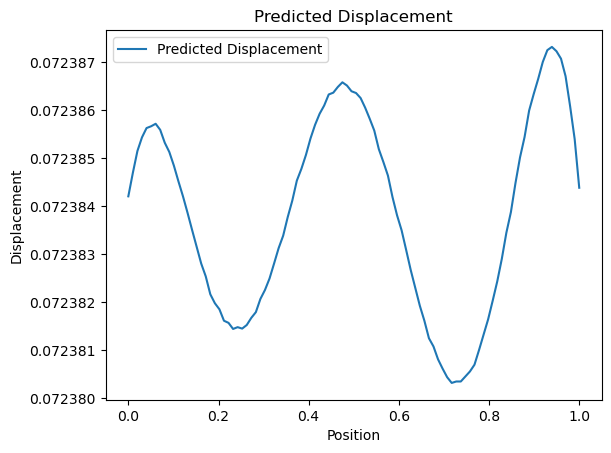

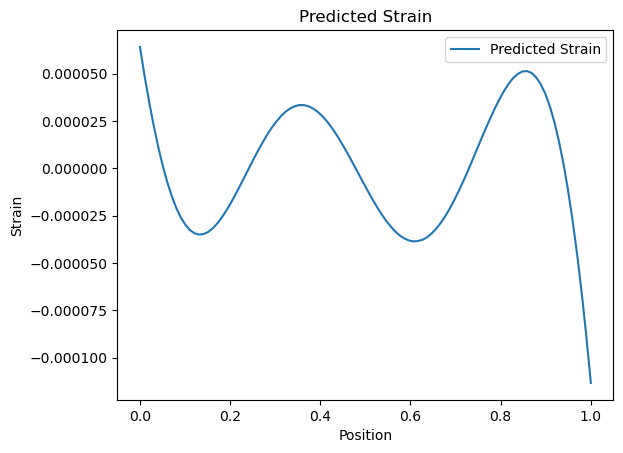

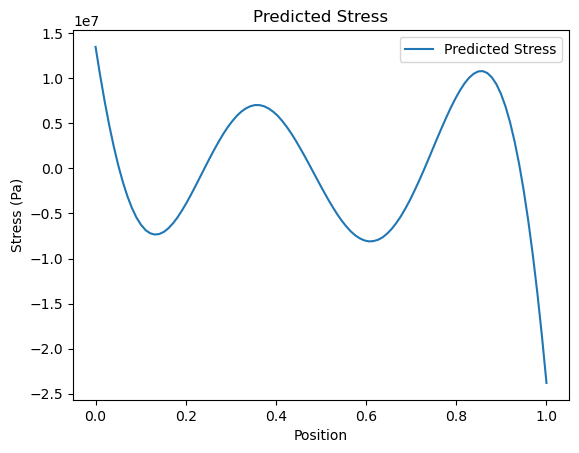

In [10]:
# Visualization of predicted displacement, strain, and stress
x_test = jnp.linspace(0, 1, 100).reshape(-1, 1)  # our Test data

# Predicted displacement
displacement_pred = jax.vmap(model)(x_test)

plt.figure()
plt.plot(x_test, displacement_pred, label='Predicted Displacement')
plt.xlabel('Position')
plt.ylabel('Displacement')
plt.title('Predicted Displacement')
plt.legend()
plt.show()

# Predicted strain
strain_pred = jax.vmap(lambda x: jax.grad(lambda x: model(x).sum())(x))(x_test)

plt.figure()
plt.plot(x_test, strain_pred, label='Predicted Strain')
plt.xlabel('Position')
plt.ylabel('Strain')
plt.title('Predicted Strain')
plt.legend()
plt.show()

# Predicted stress
stress_pred = E * strain_pred

plt.figure()
plt.plot(x_test, stress_pred, label='Predicted Stress')
plt.xlabel('Position')
plt.ylabel('Stress (Pa)')
plt.title('Predicted Stress')
plt.legend()
plt.show()


In [11]:
#Basic one input test
x = jnp.array([[0.2]])
pd.DataFrame(model(x).T).describe()

,0
count,64.000000
mean,-0.030723
std,0.133857
min,-0.203279
25%,-0.162667
50%,-0.059434
75%,0.117199
max,0.145074


2D HOOKE'S LAWS

In [13]:
# Constants
E = 210e9  # Young's modulus for steel in Pascals
nu = 0.3   # Poisson's ratio

In [14]:

# Multi layer perceptron PINN model 
class MLP(eqx.Module):
    layers: list
    activation: callable

    def __init__(self, key, sizes, activation=jax.nn.tanh):
        self.layers = [eqx.nn.Linear(sizes[i], sizes[i+1], key=subkey) for i, subkey in enumerate(jax.random.split(key, len(sizes) - 1))]
        self.activation = activation

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)
    
# call the Model by using random keys
key = jax.random.PRNGKey(0)
model_u = MLP(key, [2, 64, 64, 1])
model_v = MLP(key, [2, 64, 64, 1])

In [15]:
# we calculate again stress and strain residual but This time it is 2D so we use Hooke's laws in 2D
def stress_strain_residual(model_u, model_v, x):
    u = model_u(x)
    v = model_v(x)
    du_dx = jax.grad(lambda x: model_u(x).sum())(x)[0]
    dv_dy = jax.grad(lambda x: model_v(x).sum())(x)[1]
    du_dy = jax.grad(lambda x: model_u(x).sum())(x)[1]
    dv_dx = jax.grad(lambda x: model_v(x).sum())(x)[0]
    epsilon_xx = du_dx
    epsilon_yy = dv_dy
    epsilon_xy = 0.5 * (du_dy + dv_dx)
    sigma_xx = E / (1 - nu**2) * (epsilon_xx + nu * epsilon_yy)
    sigma_yy = E / (1 - nu**2) * (epsilon_yy + nu * epsilon_xx)
    sigma_xy = E / (2 * (1 + nu)) * epsilon_xy
    return sigma_xx, sigma_yy, sigma_xy
#Our loss function in tersm of difference of stress level
def loss_fn(model_u, model_v, x):
    sigma_xx, sigma_yy, sigma_xy = jax.vmap(stress_strain_residual, in_axes=(None, None, 0))(model_u, model_v, x)
    sigma_true = jnp.zeros_like(sigma_xx)  # Assuming zero stress as boundary condition
    loss = jnp.mean((sigma_xx - sigma_true)**2) + jnp.mean((sigma_yy - sigma_true)**2) + jnp.mean((sigma_xy - sigma_true)**2)
    return loss

In [16]:
# Optimization processes
optimizer = optax.adam(1e-3)
opt_state_u = optimizer.init(eqx.filter(model_u, eqx.is_array))
opt_state_v = optimizer.init(eqx.filter(model_v, eqx.is_array))

@eqx.filter_jit
def train_step(model_u, model_v, opt_state_u, opt_state_v, x):
    loss, grads = eqx.filter_value_and_grad(loss_fn, has_aux=False)(model_u, model_v, x)
   # grads_u, grads_v = grads
    updates_u, opt_state_u = optimizer.update(grads, opt_state_u)
    updates_v, opt_state_v = optimizer.update(grads, opt_state_v)
    model_u = eqx.apply_updates(model_u, updates_u)
    model_v = eqx.apply_updates(model_v, updates_v)
    return model_u, model_v, opt_state_u, opt_state_v, loss


In [18]:
#Epoch processes by training our model in  train step
loss_history = []
x_train = jnp.array([[i, j] for i in jnp.linspace(0, 1, 100) for j in jnp.linspace(0, 1, 100)])
for epoch in range(10000):
    model_u, model_v, opt_state_u, opt_state_v, loss = train_step(model_u, model_v, opt_state_u, opt_state_v, x_train)
    loss_history.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 4.5098701861641676e+20
Epoch 100, Loss: 7.495500069116418e+19
Epoch 200, Loss: 5.355055934362092e+18
Epoch 300, Loss: 2.89214823887641e+18
Epoch 400, Loss: 1.6258652987394621e+18
Epoch 500, Loss: 9.57362778807468e+17
Epoch 600, Loss: 6.050103276328714e+17
Epoch 700, Loss: 4.3030284342185165e+17
Epoch 800, Loss: 3.49530039185834e+17
Epoch 900, Loss: 3.116310072477614e+17
Epoch 1000, Loss: 2.892274270396744e+17
Epoch 1100, Loss: 2.6979465853036134e+17
Epoch 1200, Loss: 2.4849966092097946e+17
Epoch 1300, Loss: 2.241149325583319e+17
Epoch 1400, Loss: 1.971211833620562e+17
Epoch 1500, Loss: 1.6883243280655974e+17
Epoch 1600, Loss: 1.4086024711058227e+17
Epoch 1700, Loss: 1.147128899394601e+17
Epoch 1800, Loss: 9.150979297928806e+16
Epoch 1900, Loss: 7.185299468084838e+16
Epoch 2000, Loss: 5.584974467248947e+16
Epoch 2100, Loss: 4.323423172322918e+16
Epoch 2200, Loss: 3.35306486185984e+16
Epoch 2300, Loss: 2.618671410393907e+16
Epoch 2400, Loss: 2.0675162961608704e+16
Epoch 25

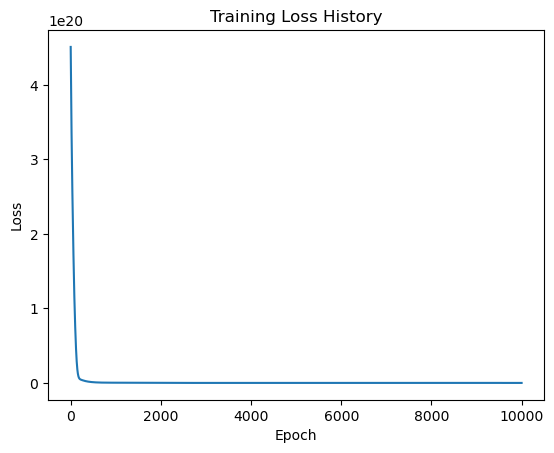

In [22]:
#Loss function visualization
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

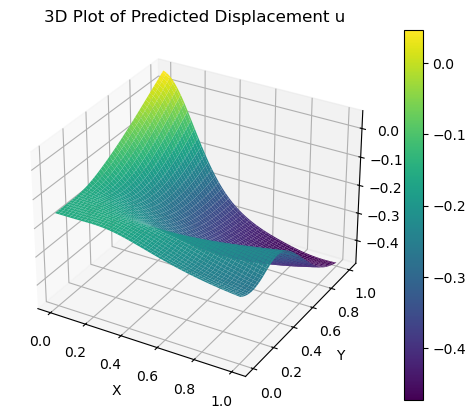

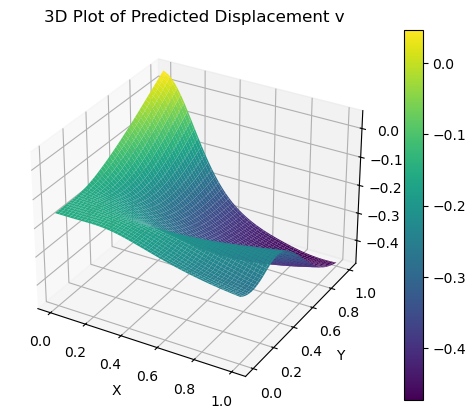

In [24]:

# Test and Visualize Results
x_test = jnp.array([[i, j] for i in jnp.linspace(0, 10, 100) for j in jnp.linspace(0, 10, 100)])
displacement_u_pred = jax.vmap(model_u)(x_test).reshape(100, 100)
displacement_v_pred = jax.vmap(model_v)(x_test).reshape(100, 100)
x_plot = jnp.linspace(0, 1, 100)
y_plot = jnp.linspace(0, 1, 100)
x_plot, y_plot = jnp.meshgrid(x_plot, y_plot)

# 3D Plot for Displacement u
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf_u = ax.plot_surface(x_plot, y_plot, displacement_u_pred, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Displacement u')
ax.set_title('3D Plot of Predicted Displacement u')
fig.colorbar(surf_u)
plt.show()

# 3D Plot for Displacement v
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf_v = ax.plot_surface(x_plot, y_plot, displacement_v_pred, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Displacement v')
ax.set_title('3D Plot of Predicted Displacement v')
fig.colorbar(surf_v)
plt.show()


In [26]:

# Function to prompt user inputs and predict displacement
def predict_displacement(x_input, y_input):
    input_point = jnp.array([[x_input, y_input]]).T
    u_pred = model_u(input_point)
    v_pred = model_v(input_point)
    return u_pred, v_pred

# Calculate Strain Components
def calculate_strain(model_u, model_v, point):
    du_dx = jax.grad(lambda x: model_u(x).sum())(point)[0]
    dv_dy = jax.grad(lambda x: model_v(x).sum())(point)[1]
    du_dy = jax.grad(lambda x: model_u(x).sum())(point)[1]
    dv_dx = jax.grad(lambda x: model_v(x).sum())(point)[0]
    epsilon_xx = du_dx
    epsilon_yy = dv_dy
    epsilon_xy = 0.5 * (du_dy + dv_dx)
    return epsilon_xx, epsilon_yy, epsilon_xy

# Calculate Stress Components
def calculate_stress(epsilon_xx, epsilon_yy, epsilon_xy):
    sigma_xx = E / (1 - nu**2) * (epsilon_xx + nu * epsilon_yy)
    sigma_yy = E / (1 - nu**2) * (epsilon_yy + nu * epsilon_xx)
    sigma_xy = E / (2 * (1 + nu)) * epsilon_xy
    return sigma_xx, sigma_yy, sigma_xy

# Example usage: Predict displacement, strain, and stress at a given point
x_input = 0.2
y_input = 0.2
u_pred, v_pred = predict_displacement(x_input, y_input)
epsilon_xx, epsilon_yy, epsilon_xy = calculate_strain(model_u, model_v, jnp.array([[x_input, y_input]]).T)
sigma_xx, sigma_yy, sigma_xy = calculate_stress(epsilon_xx, epsilon_yy, epsilon_xy)
cross_sectional_area = 1.0  # For simplicity, using unit area
force_xx = sigma_xx * cross_sectional_area
force_yy = sigma_yy * cross_sectional_area
force_xy = sigma_xy * cross_sectional_area
print(f"Predicted displacement at ({x_input}, {y_input}): u = {pd.DataFrame(u_pred.T).describe()}, v = {pd.DataFrame(v_pred.T).describe()}")
print(f"Predicted strain at ({x_input}, {y_input}): epsilon_xx = {epsilon_xx}, epsilon_yy = {epsilon_yy}, epsilon_xy = {epsilon_xy}")
print(f"Predicted stress at ({x_input}, {y_input}): sigma_xx = {sigma_xx}, sigma_yy = {sigma_yy}, sigma_xy = {sigma_xy}")
print(f"Predicted force at ({x_input}, {y_input}): force_xx = {force_xx}, force_yy = {force_yy}, force_xy = {force_xy}")

Predicted displacement at (0.2, 0.2): u =                0
count  64.000000
mean   -0.035412
std     0.056312
min    -0.131506
25%    -0.086766
50%    -0.042918
75%     0.021302
max     0.052470, v =                0
count  64.000000
mean   -0.035412
std     0.056312
min    -0.131506
25%    -0.086766
50%    -0.042918
75%     0.021302
max     0.052470
Predicted strain at (0.2, 0.2): epsilon_xx = [-0.99820703], epsilon_yy = [0.37351927], epsilon_xy = [-0.3123439]
Predicted stress at (0.2, 0.2): sigma_xx = [-2.0449644e+11], sigma_yy = [1.7090115e+10], sigma_xy = [-2.5227776e+10]
Predicted force at (0.2, 0.2): force_xx = [-2.0449644e+11], force_yy = [1.7090115e+10], force_xy = [-2.5227776e+10]


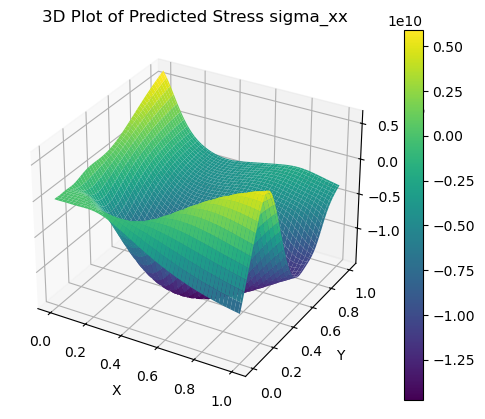

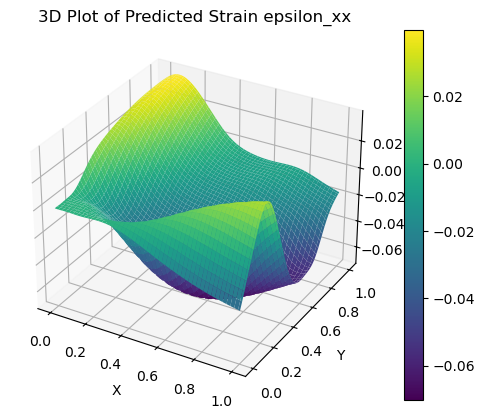

In [28]:
#Our test data for both stress and also strain
x_test = jnp.array([[i, j] for i in jnp.linspace(0, 10, 100) for j in jnp.linspace(0, 10, 100)])
epsilon_xx, epsilon_yy, epsilon_xy = jax.vmap(calculate_strain, in_axes=(None, None, 0))(model_u, model_v, x_test)
sigma_xx, sigma_yy, sigma_xy = jax.vmap(calculate_stress)(epsilon_xx, epsilon_yy, epsilon_xy)

# 3D Visualization of Stress_xx
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_plot, y_plot = jnp.meshgrid(jnp.linspace(0, 1, 100), jnp.linspace(0, 1, 100))
surf_sigma_xx = ax.plot_surface(x_plot, y_plot, sigma_xx.reshape(100, 100), cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Stress sigma_xx')
ax.set_title('3D Plot of Predicted Stress sigma_xx')
fig.colorbar(surf_sigma_xx)
plt.show()

# 3D Visualization of Strain_xx
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf_epsilon_xx = ax.plot_surface(x_plot, y_plot, epsilon_xx.reshape(100, 100), cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Strain epsilon_xx')
ax.set_title('3D Plot of Predicted Strain epsilon_xx')
fig.colorbar(surf_epsilon_xx)
plt.show()

